In [1]:
import rasterio as rio
import numpy as np
from landsat_processing_utils import histogram_stretch
from rasterio.plot import show
from scipy.ndimage import generic_filter, uniform_filter

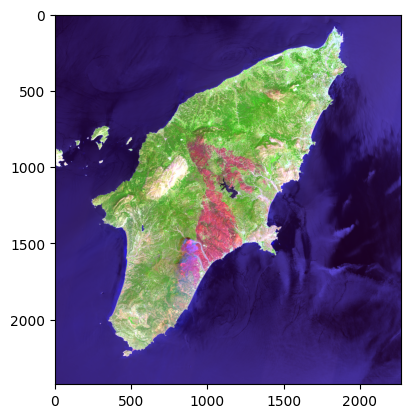

<Axes: >

In [2]:
# View image
with rio.open('20230726_TOA/LC08_L1TP_180035_20230726_20230804_02_T1_TOA_STACKED.tif') as src:
    profile = src.profile
    stack = src.read()
    src.close()
    
stretch_tcc = histogram_stretch(stack[[6,4,1],...], 0, 99)

show(stretch_tcc)

In [3]:
# Extract stacks for clarity
band = dict()

for i in range(7):
    band[i+1] = stack[i, ...]

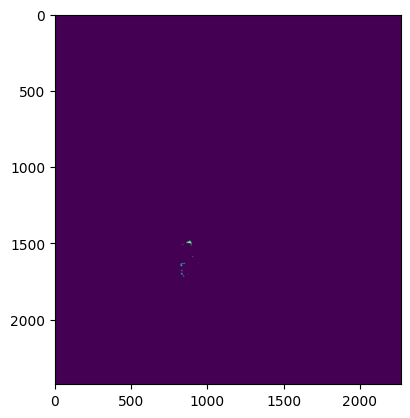

<Axes: >

In [50]:
### Active Fire Detection
def dn_folding(band):
    '''
    Input: Dictionary containing bands with keys 1-7
    Identify DN folding, which indicates an unambiguous fire pixel.
    
    Returns a boolean array indicating if a pixel has undergone folding
    
    '''
    condition_2 = ((band[6] > 0.8) & (band[1] < 0.2) & ((band[5] > 0.4) | (band[7] < 0.1))) 
    
    return condition_2


# Attempt to detect active fire pixels based on the following condition:
# R75 > 2.5 AND p7-p5 > 0.3 AND p7 > 0.5

# UAFP = unambiguous active fire pixel
def unambiguous_fire(band, dn_folded):
    '''
    Input: Dictionary containing bands with keys 1-7
    Input: dn_folded - boolean array indicating DN folded pixels
    
    Returns a NumPy boolean array containing true values where unambiguous 
    fire pixels were detected.
    '''
    uafp = ((band[7] / band[5]) > 2.5) & ((band[7] - band[5]) > 0.3) & (band[7] > 0.5)
    
    uafp = (uafp | dn_folded)
    
    return uafp
dn_folded = dn_folding(band)
fire_mask = unambiguous_fire(band, dn_folded)

show(fire_mask)

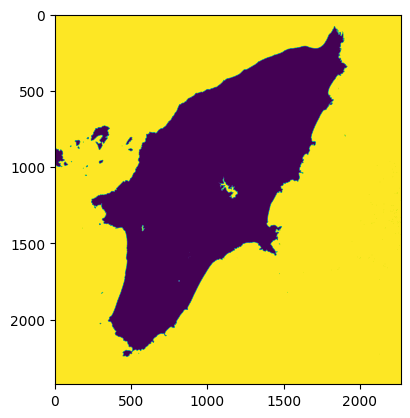

<Axes: >

In [5]:
def water(band):
    '''
    Used to detect water pixels (both ocean and inland water bodies)
    
    Input: Dictionary containing bands with keys 1-7
    
    Returns a NumPy boolean array containing true values where water pixels were detected.
    '''
    condition_1 = band[4] > band[5]
    condition_2 = band[5] > band[6]
    condition_3 = band[6] > band[7]
    condition_4 = (band[1] - band[7]) < 0.2
    
    test_1 = (condition_1 & condition_2 & condition_3 & condition_4)
    
    condition_5 = band[3] > band[2]
    condition_6 = band[1] > band[2]
    condition_7 = band[2] > band[3]
    condition_8 = band[3] > band[4]
    
    test_2 = ((condition_5) | (condition_6 & condition_7 & condition_8))
    
    return (test_1 & test_2)
    
water_mask = water(band)

show(water_mask)

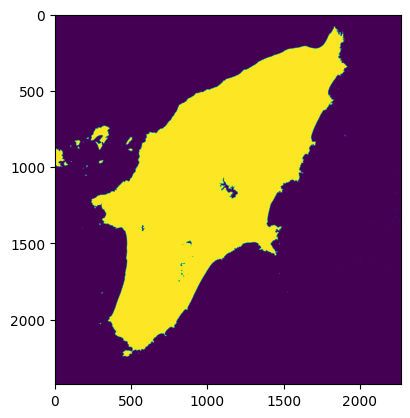

<Axes: >

In [6]:
def background(unambiguous_array, water_array):
    '''
    Used to identify valid background pixels. These pixels are used in the calculation of the mean and stddev values required
    for threshold and contextual tests for potential fire pixel detection
    
    Returns a boolean array indicating whether a pixel is a valid background pixel.
    '''
    # background array is anything that isn't a unambgiuous fire OR water pixel
    background = np.invert(unambiguous_array | water_array)
    
    # and band[7] > 0
    background = (background & (band[7] > 0))
    
    return background

background_mask = background(fire_mask, water_mask)

show(background_mask)

In [104]:
def potential_fire(band, background_mask, size = 61):
    '''
    This helps classify potential fire pixels. First, it conducts threshold and contextual tests to determine if the 
    pixel is valid, then checks if it meets the other requirements.
    
    band: Dict with keys 1-7 containing reflectance bands 1-7 
    background_mask: boolean array of valid background pixels (i.e., not water or fire) 
    '''
    # background_mask = True/False
    # background_array = 1./0.
    # background_array = background_mask.astype(np.float32)
    
    # this is used to get back the actual means from uniform_filter
    weights = uniform_filter(background_array, size = size)
    
    ratio75 = band[7] / band[5]
    
    # masked version of band7 and ratio75 where invalid pixels are set to 0.
    band7_bgmasked = background_mask * band[7]
    ratio75_bgmasked = background_mask * ratio75
    
    with np.errstate(divide = 'ignore', invalid = 'ignore'):
        ### vectorized mean of band 7
        # mean of the 61x61 kernel, but includes 0s
        band7_uf = uniform_filter(band7_bgmasked, size = size)

        # true mean of the 61x61 kernel, not including 0s
        # use weights > 1/size to avoid floating point errors
        band7_mean = np.where(weights > (1/size), band7_uf/weights, np.nan)

        # convert nans to 0 for later calcs.
        band7_mean = np.nan_to_num(band7_mean, nan=0)

        ### vectorized mean of ratio75
        ratio75_uf = uniform_filter(ratio75_bgmasked, size = size)
        ratio75_mean = np.where(weights > (1/size), ratio75_uf/weights, np.nan)
        ratio75_mean = np.nan_to_num(ratio75_mean, nan=0)

        ### vectorized calc of band7
        # std = sqrt(mean(X^2) - (mean(X))^2)
        # calc mean of band7 squared
        band7_sq = band7_bgmasked ** 2

        band7_sq_uf = uniform_filter(band7_sq, size = size)
        band7_sq_mean = np.where(weights > (1/size), band7_sq_uf/weights, np.nan)
        band7_sq_mean = np.nan_to_num(band7_sq_mean, nan=0)

        band7_std = np.sqrt(band7_sq_mean - (band7_mean)**2)

        ### vectorized stddev of ratio75
        ratio75_sq = ratio75_bgmasked ** 2

        ratio75_sq_uf = uniform_filter(ratio75_sq, size = size)
        ratio75_sq_mean = np.where(weights > (1/size), ratio75_sq_uf/weights, np.nan)
        ratio75_sq_mean = np.nan_to_num(ratio75_sq_mean, nan=0)

        ratio75_std = np.sqrt(ratio75_sq_mean - (ratio75_mean)**2)

        ### threshold tests
        band7_add = np.where(band7_std*3 < 0.8, 0.8, band7_std*3)
        ratio75_add = np.where(ratio75_std*3 < 0.8, 0.8, ratio75_std*3)

        threshold_1 = ratio75 > (ratio75_mean + ratio75_add)
        threshold_2 = band[7] > (band7_mean + band7_add)
        threshold_3 = (band[7] / band[6]) > 1.6

        condition_1 = (threshold_1 & threshold_2 & threshold_3)

        ### candidates
        condition_2 = (ratio75 > 1.8) & (band[7] - band[5] > 0.17)
    
    potential_array = (condition_1 & condition_2 & background_mask)
    
    return potential_array


In [121]:
def test_potential_fire(band, background_mask, size = 61):
    '''
    This helps classify potential fire pixels. First, it conducts threshold and contextual tests to determine if the 
    pixel is valid, then checks if it meets the other requirements.
    
    band: Dict with keys 1-7 containing reflectance bands 1-7 
    background_mask: boolean array of valid background pixels (i.e., not water or fire) 
    '''
    # background_mask = True/False
    # background_array = 1./0.
    # background_array = background_mask.astype(np.float32)
    
    # this is used to get back the actual means from uniform_filter
    weights = uniform_filter(background_array, size = size)
    
    ratio75 = band[7] / band[5]
    
    # masked version of band7 and ratio75 where invalid pixels are set to 0.
    band7_bgmasked = background_mask * band[7]
    ratio75_bgmasked = background_mask * ratio75
    
    with np.errstate(divide = 'ignore', invalid = 'ignore'):
        ### vectorized mean of band 7
        # mean of the 61x61 kernel, but includes 0s
        band7_uf = uniform_filter(band7_bgmasked, size = size)

        # true mean of the 61x61 kernel, not including 0s
        # use weights > 1/size to avoid floating point errors
        band7_mean = np.where(weights > (1/size), band7_uf/weights, np.nan)

        # convert nans to 0 for later calcs.
        band7_mean = np.nan_to_num(band7_mean, nan=0)

        ### vectorized mean of ratio75
        ratio75_uf = uniform_filter(ratio75_bgmasked, size = size)
        ratio75_mean = np.where(weights > (1/size), ratio75_uf/weights, np.nan)
        ratio75_mean = np.nan_to_num(ratio75_mean, nan=0)

        ### vectorized calc of band7
        # std = sqrt(mean(X^2) - (mean(X))^2)
        # calc mean of band7 squared
        band7_sq = band7_bgmasked ** 2

        band7_sq_uf = uniform_filter(band7_sq, size = size)
        band7_sq_mean = np.where(weights > (1/size), band7_sq_uf/weights, np.nan)
        band7_sq_mean = np.nan_to_num(band7_sq_mean, nan=0)

        band7_std = np.sqrt(band7_sq_mean - (band7_mean)**2)

        ### vectorized stddev of ratio75
        ratio75_sq = ratio75_bgmasked ** 2

        ratio75_sq_uf = uniform_filter(ratio75_sq, size = size)
        ratio75_sq_mean = np.where(weights > (1/size), ratio75_sq_uf/weights, np.nan)
        ratio75_sq_mean = np.nan_to_num(ratio75_sq_mean, nan=0)

        ratio75_std = np.sqrt(ratio75_sq_mean - (ratio75_mean)**2)

        ### threshold tests
        band7_add = np.where(band7_std*3 < 0.8, 0.8, band7_std*3)
        ratio75_add = np.where(ratio75_std*3 < 0.8, 0.8, ratio75_std*3)

        threshold_1 = ratio75 > (ratio75_mean + ratio75_add)
        threshold_2 = band[7] > (band7_mean + band7_add)
        threshold_3 = (band[7] / band[6]) > 1.6

        condition_1 = (threshold_1 & threshold_2 & threshold_3)

        ### candidates
        condition_2 = (ratio75 > 1.8) & (band[7] - band[5] > 0.17)
    
    potential_array = (condition_1 & condition_2 & background_mask)
    
    return condition_1 * background_mask


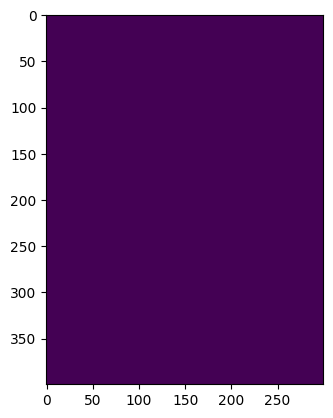

<Axes: >

In [122]:
show(test_potential_fire(band, background_mask)[1400:1800, 700:1000], interpolation = 'nearest')

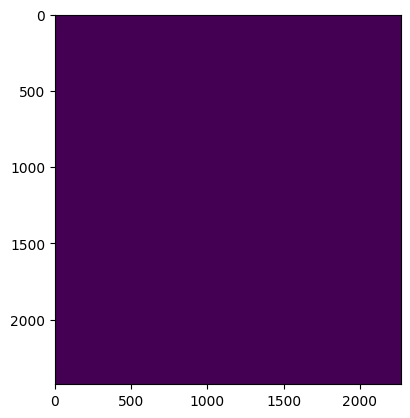

<Axes: >

In [106]:
pfire = potential_fire(band, background_mask)

# show(pfire[1450:1550, 800:900])
show(pfire)

In [108]:
def create_fire_detection_array(band, size = 61):
    '''
    Combines all of the above functions and classifies your raster
    
    inputs: band - dict with keys 1-7 containing the reflectances in bands 1-7s
            size - size of kernel to use for background checks; default 61 as according to Schroeder et al. 2016
    '''
    
    # create dn_folding and background_masks
    dn_folded = dn_folding(band)
    water_mask = water(band)
    fire_mask = unambiguous_fire(band, dn_folded)
    
    background_mask = background(fire_mask, water_mask)
    
    pfire_mask = potential_fire(band, background_mask, size)
    
    fire_detection = np.zeros((band[1].shape[0], band[1].shape[1]))
    
    fire_detection = fire_detection + pfire_mask
    fire_detection = fire_detection + (fire_mask * 2)
    
    return fire_detection

detected_fires = create_fire_detection_array(band)    

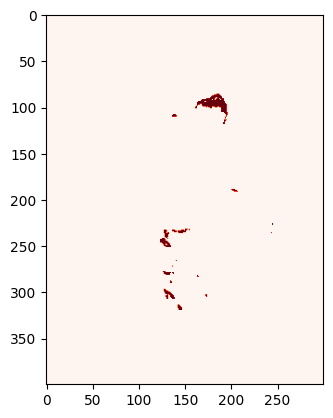

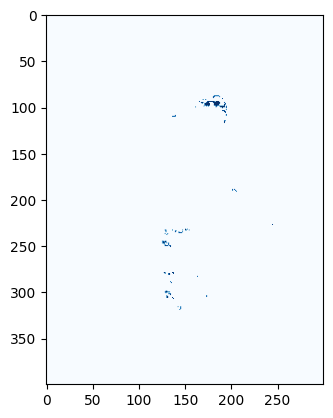

<Axes: >

In [84]:
show(fire_mask[1400:1800, 700:1000], cmap = 'Reds')
show(pfire[1400:1800, 700:1000], cmap = 'Blues')

In [ ]:
show(fire_mask[1400:1800, 700:1000], cmap = 'Reds')

<Axes: >

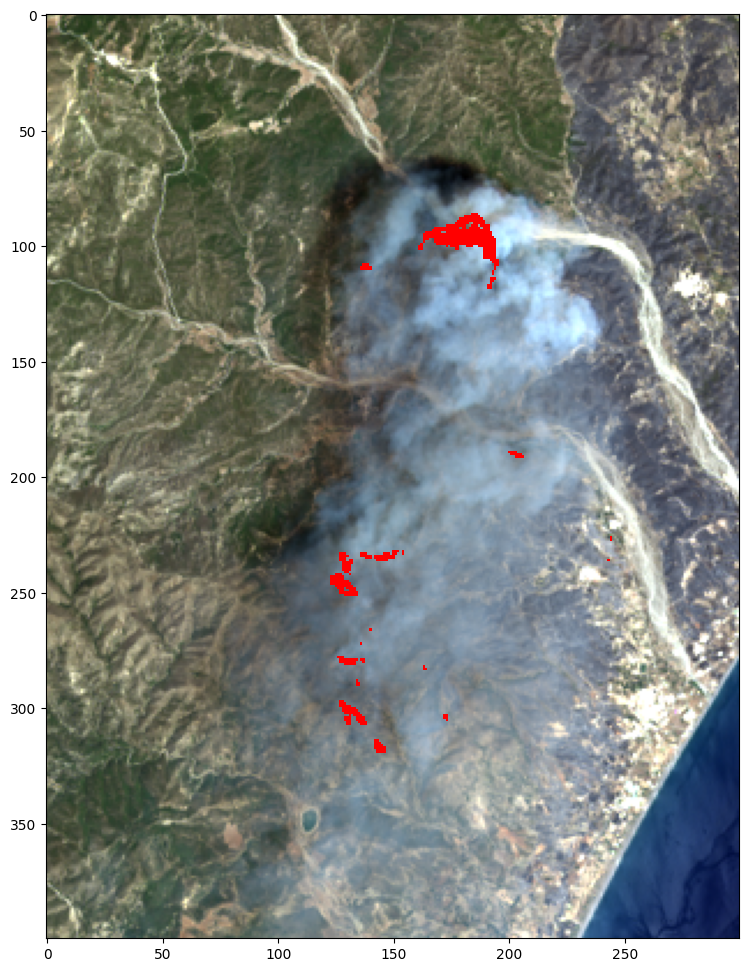

In [111]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

cmap = ListedColormap(['none', 'orange', 'red'])

fig, ax = plt.subplots(figsize = (12,12))
show(histogram_stretch(stack[[3,2,1],1400:1800, 700:1000], 0, 99), ax = ax)
show(detected_fires[1400:1800, 700:1000], cmap = cmap, ax = ax, interpolation = 'nearest')
# show(fire_mask[1400:1800, 700:1000], cmap = 'Blues', alpha = 0.5, ax = ax)

In [96]:
detected_fires[detected_fires == 3]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

In [60]:
np.array([True, True, False]) * 2

array([2, 2, 0])

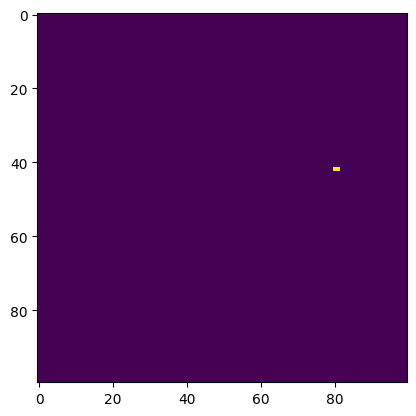

<Axes: >

In [49]:
show(dn_folding(band)[1450:1550, 800:900])

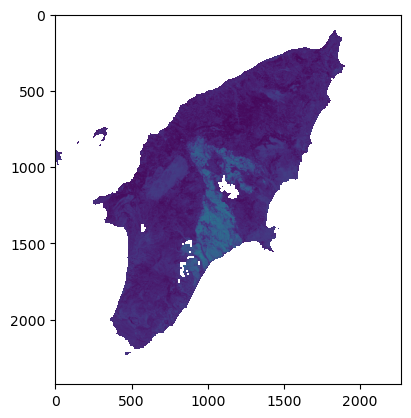

<Axes: >

In [18]:
ratio75 = np.where(background_mask, band[7] / band[5], np.nan)

show(ratio75)

<timed exec>:18: RuntimeWarning: invalid value encountered in divide


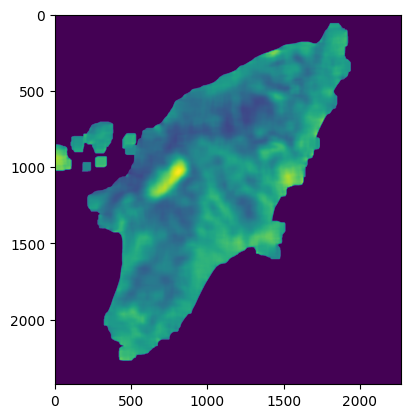

CPU times: total: 1.05 s
Wall time: 1.04 s


<Axes: >

In [16]:
%%time
# def nan_std(image):
#     try:
#         return np.nanstd(image)
#     except:
#         return np.nan


# background_mask = True/False
# background_array = 1./0.
background_array = background_mask.astype(np.float32)
weights = uniform_filter(background_array, size = 61)

size = 61

band7_bgmasked = background_mask * band[7]

band7_uf = uniform_filter(band7_bgmasked, size = size)
band7_mean = np.where(weights > (1/size), band7_uf/weights, np.nan)
band7_mean = np.nan_to_num(band7_mean, nan=0)

show(band7_mean)

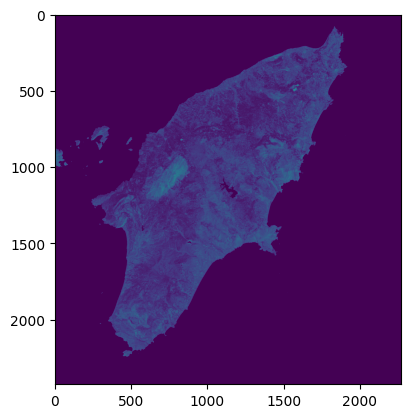

<Axes: >

In [29]:
# std = mean(X^2) - (mean(X))^2
show(band7_bgmasked)

C:\Users\Jonny\AppData\Local\Temp\ipykernel_4312\1103053542.py:4: RuntimeWarning: invalid value encountered in divide
  band7_sq_mean = np.where(weights > (1/size), band7_sq_uf/weights, np.nan)


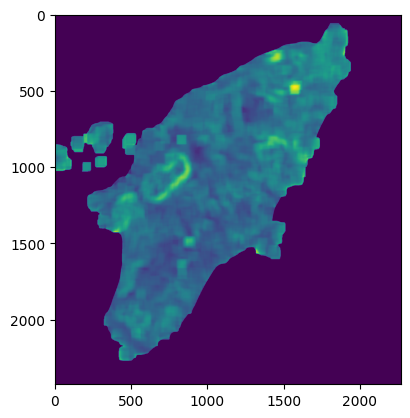

<Axes: >

In [31]:
band7_sq = band7_bgmasked ** 2

band7_sq_uf = uniform_filter(band7_sq, size = size)
band7_sq_mean = np.where(weights > (1/size), band7_sq_uf/weights, np.nan)
band7_sq_mean = np.nan_to_num(band7_sq_mean, nan=0)

band7_std = np.sqrt(band7_sq_mean - (band7_mean)**2)

show(band7_std)

In [24]:
band7_std[900:1000, 0:100]

array([[0.01189448, 0.01168568, 0.00995145, ..., 0.        , 0.        ,
        0.        ],
       [0.01442717, 0.01254659, 0.00965652, ..., 0.        , 0.        ,
        0.        ],
       [0.01807461, 0.01474938, 0.01046925, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.3097335 , 0.30944306, 0.30890486, ..., 0.6924742 , 0.7274034 ,
        0.7622848 ],
       [0.31561264, 0.31540436, 0.3149599 , ..., 0.7038493 , 0.7401018 ,
        0.77691984],
       [0.3212387 , 0.32120046, 0.32100976, ..., 0.7169262 , 0.7526853 ,
        0.79128927]], dtype=float32)

In [25]:
band7_mean[900:1000, 0:100]

array([[0.21615534, 0.21590017, 0.21547435, ..., 0.        , 0.        ,
        0.        ],
       [0.21631259, 0.21607164, 0.2156784 , ..., 0.        , 0.        ,
        0.        ],
       [0.21633363, 0.2161224 , 0.21577343, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.22463506, 0.22479388, 0.22481617, ..., 0.20723711, 0.2063849 ,
        0.2043328 ],
       [0.2247609 , 0.22492576, 0.22494905, ..., 0.20839806, 0.20766312,
        0.20571631],
       [0.22505902, 0.22523013, 0.22525468, ..., 0.20988168, 0.20863825,
        0.20677356]], dtype=float32)

In [26]:
band[7][900:1000, 0:100]

array([[0.21928, 0.22408, 0.22692, ..., 0.0089 , 0.00752, 0.00844],
       [0.23382, 0.22524, 0.21868, ..., 0.00788, 0.00778, 0.00832],
       [0.22884, 0.2324 , 0.21448, ..., 0.00768, 0.00768, 0.0083 ],
       ...,
       [0.02726, 0.02732, 0.028  , ..., 0.02218, 0.02256, 0.0224 ],
       [0.02626, 0.0273 , 0.02812, ..., 0.02278, 0.0231 , 0.0225 ],
       [0.02698, 0.02714, 0.02734, ..., 0.02366, 0.02318, 0.02308]],
      dtype=float32)

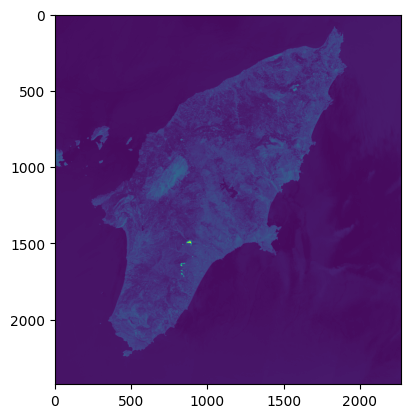

<Axes: >

In [27]:
show(band[7])

In [2]:
test = np.arange(1,82).reshape(9,9)

test_mask = np.zeros((9,9))

test_mask[1:4,1:4] = 1

test_masked = np.where(test_mask, test, np.nan)

test_masked

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, 11., 12., 13., nan, nan, nan, nan, nan],
       [nan, 20., 21., 22., nan, nan, nan, nan, nan],
       [nan, 29., 30., 31., nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [5]:
# ndimage does NOT respect masks - need to mask the image manually with np.nan
# then use the appropriate np function that ignores np.nan
# test_filter = generic_filter(test_masked, np.nanstd, (3,3))
test_filter = uniform_filter(test_masked, size = 3)

test_filter

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan]])

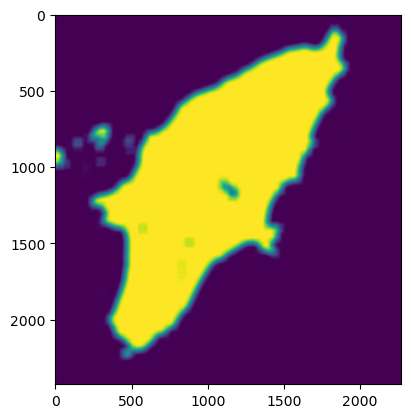

<Axes: >

In [15]:
bg_mask = background_mask.astype(np.float32)
weights = uniform_filter(bg_mask.astype(np.float32), size = 61)

show(weights)

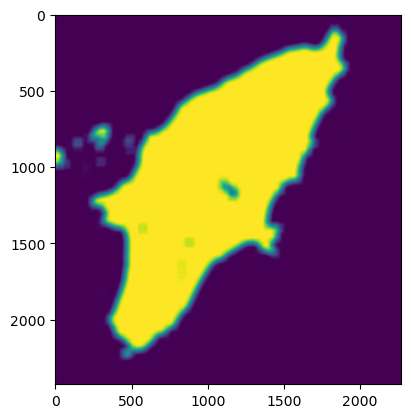

<Axes: >

In [14]:
show(weights)